In [6]:
#import packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import random as rd
import time as time

In [7]:
#Q1 (a)

# Load the data
df1 = pd.read_csv('/Users/charleswong/Desktop/PHYS3151_asm5_version_control/Ising_config_L12.csv', header=None)
df2 = pd.read_csv('/Users/charleswong/Desktop/PHYS3151_asm5_version_control/T_data_L12.csv', header=None)
X = df1.to_numpy()  # Convert the DataFrame to a NumPy array
T = df2.to_numpy()  # Convert the DataFrame to a NumPy array


"""Using methods provided by lecture notes"""
z = np.zeros(X.shape)  # Create an array of zeros with the same shape as x

x_mean = np.mean(X, axis=0)

x_std = np.std(X, axis=0, ddof=0)

# Standardize each feature correctly
for i in range(X.shape[1]):
    z[:,i] = (X[:,i] - x_mean[i]) / x_std[i]


#(b)
Y = np.zeros(T.shape)  # Create an array of zeros with the same shape as t
for i in range(T.shape[0]):
    T[i] = 0 if T[i] > 1.51 else 1
    Y[i] = T[i]


(6400, 288)


In [8]:
######################################################################################
#Q2 (a)b)

# #define parameters for neurons, hidden layers, and output neurons
Parameter_list_a = [288, 3, 1]  # [input neurons, nodes of hidden neurons, output neurons]
num_layers_a = len(Parameter_list_a)  # number of layers
theta_1st_network = [np.random.random((Parameter_list_a[i+1], Parameter_list_a[i] + 1)) - 0.5 for i in range(num_layers_a - 1)]
print("Shape of theta_1st_network:", theta_1st_network[0].shape)

Parameter_list_b = [288, 3, 3, 1] # [input neurons, nodes of hidden neurons, output neurons]
num_layers_b = len(Parameter_list_b)  # number of layers
theta_2nd_network = [np.random.random((Parameter_list_b[i+1], Parameter_list_b[i] + 1)) - 0.5 for i in range(num_layers_b - 1)]

def sigmoid(x): # sigmoid function is chosen as the activation function, there are other options which will be discussed later
    return 1 / (1 + np.exp(-x))


def compute_accuracy(theta, X_test, Y_test):
    # Initialize counter for correct predictions.
    correct_count = 0
    # Determine the total number of test samples.
    M_test = X_test.shape[0]
    
    # Loop over each test sample.
    for sample_idx in range(M_test):
        # Extract the current sample as a column vector.
        sample = X_test[[sample_idx], :].T  
        
        # Augment the input with a bias unit by vertically stacking a row of ones.
        activation = np.vstack((np.ones((1, 1)), sample))
        
        # Forward propagate through the network layers.
        for w in theta:
            # Compute the weighted input (z) for the current layer.
            z_val = np.dot(w, activation)
            # Apply the sigmoid activation function and add bias to the result.
            activation = np.vstack((np.ones((1, 1)), sigmoid(z_val)))
        
        # Remove the bias row from the final activation to get the network's output.
        output = activation[1:]
        
        # Threshold the output at 0.5 and convert Boolean result to an integer prediction.
        # The condition checks if all or any activation values exceed 0.5.
        predicted = int((output > 0.5).all() or (output > 0.5).any())
        
        # If the predicted label matches the true label for this sample, increment the counter.
        if predicted == Y_test[sample_idx]:
            correct_count += 1
    
    # Return the overall accuracy as a percentage.
    return (correct_count / M_test) * 100

def propagation(theta, X_train, X_test, Y_train, Y_test):
    # Set initial learning rate and number of iterations (epochs)
    alpha = 4 
    n_itr = 1000
    # Initialize lists to record cost and accuracies for each iteration
    cost_history = []
    acc_train_history = []
    acc_test_history = []

    # Start timer for performance measurement
    start_time = time.time()
    
    # Number of training samples
    M_train = X_train.shape[0]
    
    # Main training loop (each iteration is one epoch)
    for itr in range(n_itr):
        J = 0            # Accumulator for cost (error)
        acc_train = 0    # Counter for number of correct predictions on training
        # Loop through each training sample
        for data_index in range(M_train):
            # ---------------------------
            # FORWARD PROPAGATION
            # ---------------------------
            # Extract the current training sample as a column vector and add a bias unit
            x_here = X_train[[data_index], :].T  
            # print("x_here:" , x_here.shape)
            # # Extract the corresponding target label as a column vector
            y_here = Y_train[[data_index], :].T  
            
            # Initialize list to hold activations for each layer.
            # The first layer activation is the input sample with bias appended (top row = ones)
            h = [np.vstack((np.ones((1, 1)), x_here))]
            # print("h.shape:", h.shape)
            
            # Propagate through each network layer:
            # NOTE: "for l in range(theta)" is assumed to mean "for l in range(len(theta))"
            for l in range(len(theta)):
                # Compute the weighted input (z) of the current layer
                z_temp = np.dot(theta[l], h[l])
                # Apply the sigmoid activation function and add bias to the activation for the next layer.
                h.append(np.vstack((np.ones((1, 1)), sigmoid(z_temp))))
            
            # ---------------------------
            # BACK PROPAGATION
            # ---------------------------
            # Extract the corresponding target label as a column vector
            # y_here = Y_train[[data_index], :].T 
            # Remove the bias row from the final output activation to get the network output.
            h_end = h[-1][1:]
            # Compute the error between output and target
            # Ym is the difference between the network output and the true label.
            Ym = h_end - y_here
            
            # Initialize the list for storing delta values (errors) for each layer.
            delta = []
            # For the output layer, compute delta:
            # The expression (Ym * h_end * (1 - h_end)) uses element-wise multiplication
            # (Hadamard product) to combine the error with the derivative of the sigmoid.
            delta.append(2 / M_train * (Ym * h_end * (1 - h_end)))
            
            # Compute delta for the previous layer (the layer before the output)
            delta.append(theta[-1].T @ delta[-1] * h[-2] * (1 - h[-2]))
            # Update weights for the last layer using gradient descent
            theta[-1] -= alpha * delta[-2] @ h[-2].T
            
            # Backpropagate through the remaining hidden layers.
            # NOTE: "for l in range(2, theta + 1)" is interpreted as "for l in range(2, len(theta)+1)"
            for l in range(2, len(theta) + 1):
                # Compute delta for the -l-th layer. We use [1:] to ignore the bias.
                delta.append(theta[-l].T @ delta[-1][1:] * h[-l - 1] * (1 - h[-l - 1]))
                # Update weights for the -l-th layer.
                # Again, [1:] is used to ensure that bias-specific deltas are excluded.
                theta[-l] -= alpha * delta[-2][1:] @ h[-l - 1].T
            
            # Accumulate the cost for this sample using the L2 norm (Euclidean norm)
            J += np.linalg.norm(Ym, 2)
            # Increase training accuracy counter if the predicted class matches the target.
            
            # # Here, np.argmax(h_end) gives the index (class) with maximum activation.
            predicted = 1 if h_end > 0.5 else 0
            if predicted == y_here:
                acc_train += 1
            # if Y_train[data_index, np.argmax(h_end)]:
            #     acc_train += 1
        
        # Calculate average cost and training accuracy over the training set
        acc_train *= 100 / M_train
        J /= M_train
        cost_history.append(J)
        acc_train_history.append(acc_train)
        # Compute test accuracy through existing compute_accuracy function
        acc_test_history.append(compute_accuracy(theta, X_test, Y_test))
        
        # Every I iterations (I should be defined elsewhere), decay the learning rate and print progress.
        if (itr + 1) % 100 == 0:
            alpha /= 1.2
            print('Complete:', int((itr + 1) / 100))
            print('The cost of train sample is {:.6f}'.format(J))
            print('The accuracy of train sample is {:.2f}%'.format(acc_train))
            print('The accuracy of test sample is {:.2f}%'.format(acc_test_history[-1]))
    
        
    end_time = time.time()  # End timer
    elapsed_time = end_time - start_time
    print("Training time: {:.2f} seconds".format(elapsed_time))
    
    
    # Return cost and accuracy histories
    return cost_history, acc_train_history, acc_test_history



Shape of theta_1st_network: (3, 289)


shape_of_X_train: (5000, 288)
shape_of_X_test: (1400, 288)
Complete: 1
The cost of train sample is 0.302590
The accuracy of train sample is 85.48%
The accuracy of test sample is 83.29%
Complete: 2
The cost of train sample is 0.231060
The accuracy of train sample is 91.78%
The accuracy of test sample is 88.36%
Complete: 3
The cost of train sample is 0.192532
The accuracy of train sample is 93.98%
The accuracy of test sample is 89.79%
Complete: 4
The cost of train sample is 0.170709
The accuracy of train sample is 95.16%
The accuracy of test sample is 89.93%
Complete: 5
The cost of train sample is 0.156861
The accuracy of train sample is 95.66%
The accuracy of test sample is 90.57%
Complete: 6
The cost of train sample is 0.147275
The accuracy of train sample is 96.16%
The accuracy of test sample is 90.71%
Complete: 7
The cost of train sample is 0.140292
The accuracy of train sample is 96.50%
The accuracy of test sample is 91.14%
Complete: 8
The cost of train sample is 0.135038
The accura

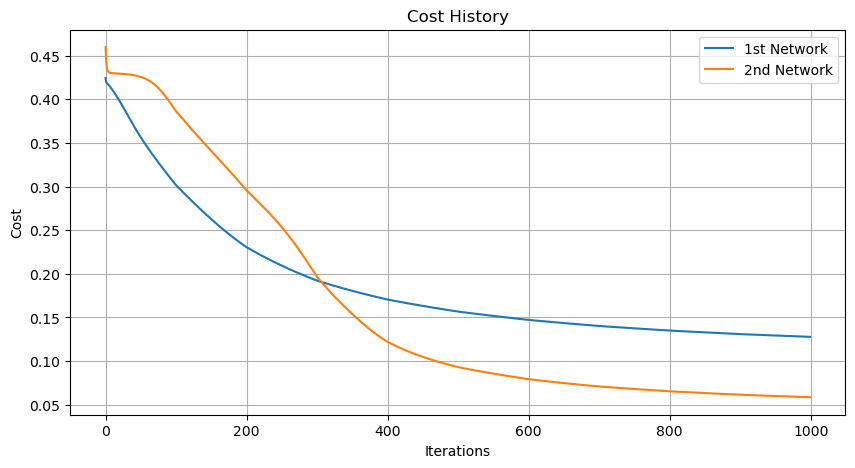

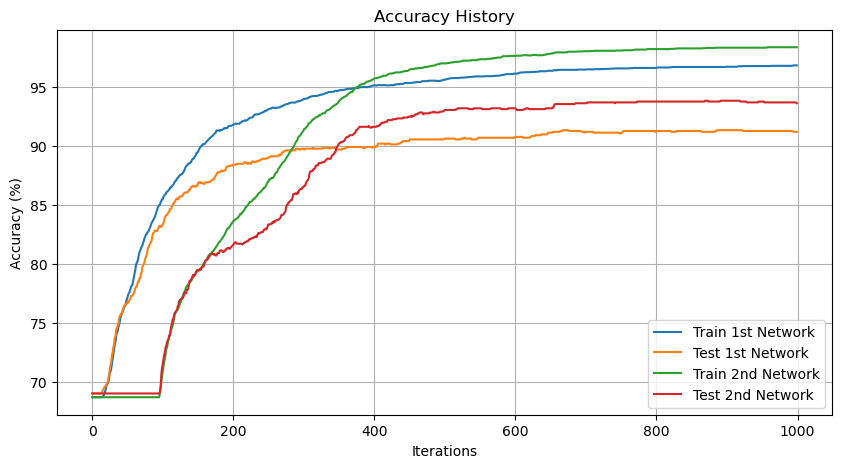

In [9]:
######################################################################################
#Q3 model training
# Split the data into training and testing sets
stack=list(range(X.shape[0]))
N_test=1400
rd.shuffle(stack)
stack_test=stack[:N_test]
stack_train=stack[N_test:]

#generate the training data
X_train = X[stack_train,:]
M_train=X_train.shape[0]
Y_train = Y[stack_train]
print("shape_of_X_train:", X_train.shape)


#generate the testing data
X_test = X[stack_test,:]
m_test=X_test.shape[0]
Y_test = Y[stack_test]
print("shape_of_X_test:", X_test.shape)

#train the first network
cost_history_a, acc_train_history_a, acc_test_history_a = propagation(theta_1st_network, X_train, X_test, Y_train, Y_test)

#train the second network
cost_history_b, acc_train_history_b, acc_test_history_b = propagation(theta_2nd_network, X_train, X_test, Y_train, Y_test)
# Plot the cost history for both networks
plt.figure(figsize=(10, 5))
plt.plot(cost_history_a, label='1st Network')
plt.plot(cost_history_b, label='2nd Network')
plt.title('Cost History')
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.legend()
plt.grid()
plt.show()
# Plot the accuracy history for both networks   
plt.figure(figsize=(10, 5))
plt.plot(acc_train_history_a, label='Train 1st Network')
plt.plot(acc_test_history_a, label='Test 1st Network')
plt.plot(acc_train_history_b, label='Train 2nd Network')
plt.plot(acc_test_history_b, label='Test 2nd Network')
plt.title('Accuracy History')
plt.xlabel('Iterations')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid()
plt.show()

output_1st_network.shape: [[0.01193073]
 [0.1224387 ]
 [0.14728465]
 ...
 [0.90958567]
 [0.90958567]
 [0.90958567]]


/var/folders/5q/j__vq1qx35s6jfnw38fm1thw0000gn/T/ipykernel_41434/173249147.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_1st_network[data_index,0] = h[-1][1:]


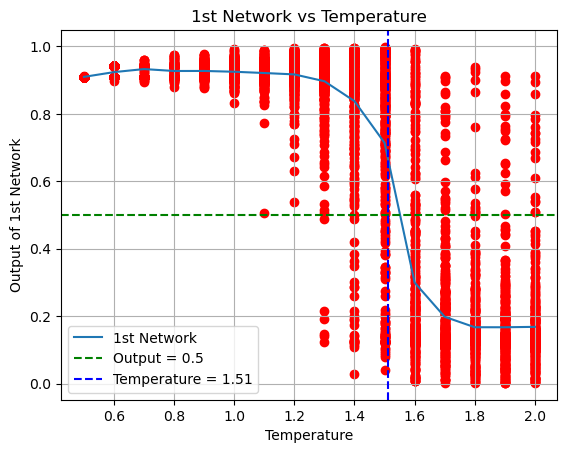

In [12]:
# Q4

df3 = pd.read_csv('/Users/charleswong/Desktop/PHYS3151_asm5_version_control/T_data_L12.csv', header=None)
T = df3.to_numpy()  # Convert the DataFrame to a NumPy array
output_1st_network = np.zeros((X.shape[0], 1))  # Initialize output array for the first network
for data_index in range(X.shape[0]):
    # ---------------------------
    # FORWARD PROPAGATION
    # ---------------------------
    # Extract the current training sample as a column vector and add a bias unit
    x_here = X[[data_index], :].T  
    # print("x_here:" , x_here.shape)
    # # Extract the corresponding target label as a column vector
    # y_here = Y_train[[data_index], :].T  
    
    # Initialize list to hold activations for each layer.
    # The first layer activation is the input sample with bias appended (top row = ones)
    h = [np.vstack((np.ones((1, 1)), x_here))]
    # print("h.shape:", h.shape)
    
    # Propagate through each network layer:
    # NOTE: "for l in range(theta)" is assumed to mean "for l in range(len(theta))"
    for l in range(len(theta_1st_network)):
        # Compute the weighted input (z) of the current layer
        z_temp = np.dot(theta_1st_network[l], h[l])
        # Apply the sigmoid activation function and add bias to the activation for the next layer.
        h.append(np.vstack((np.ones((1, 1)), sigmoid(z_temp))))
    # Remove the bias row from the final output activation to get the network's output.
    #store the output in the output_1st_network array
    output_1st_network[data_index,0] = h[-1][1:]
print("output_1st_network.shape:", output_1st_network)
            



merge = np.hstack([output_1st_network, T])  # Merge the output and temperature data
unique_T = np.unique(merge[:, 1]) # Get unique temperature values
avg_output_1st_network = []
for t_val in unique_T:
    filtered_data = merge[merge[:, 1] == t_val]
    avg_output_1st_network.append(np.mean(filtered_data[:, 0]))
    
plt.plot(unique_T, avg_output_1st_network, label='1st Network')
plt.scatter(T, output_1st_network, color='red')  # Scatter plot for clarity
plt.axhline(y=0.5, color='green', linestyle='--', label='Output = 0.5')  # Horizontal line at output 0.5
plt.axvline(x=1.51, color='blue', linestyle='--', label='Temperature = 1.51')  # Vertical line at T = 1.51
# plt.gca().invert_yaxis()  # Invert y-axis if required
plt.title('1st Network vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('Output of 1st Network')
plt.legend()
plt.grid()
plt.show()






/var/folders/5q/j__vq1qx35s6jfnw38fm1thw0000gn/T/ipykernel_41434/3804236796.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  output_2nd_network[data_index, 0] = h[-1][1:]


output_2nd_network.shape: (6400, 1)


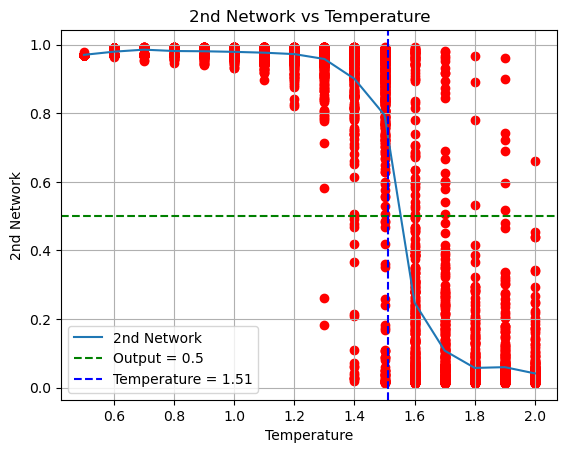

In [13]:
# Q4 - 2nd Network

# Load temperature data
df3 = pd.read_csv('/Users/charleswong/Desktop/PHYS3151_asm5_version_control/T_data_L12.csv', header=None)
T = df3.to_numpy()  # Convert the DataFrame to a NumPy array

# Initialize output array for the second network
output_2nd_network = np.zeros((X.shape[0], 1))  # Assuming X has all 6400 samples

for data_index in range(X.shape[0]):
    # ---------------------------
    # FORWARD PROPAGATION
    # ---------------------------
    # Extract the current sample as a column vector
    x_here = X[[data_index], :].T  
    # Initialize list to hold activations with bias
    h = [np.vstack((np.ones((1, 1)), x_here))]
    
    # Propagate through each network layer using theta_2nd_network
    for l in range(len(theta_2nd_network)):
        z_temp = np.dot(theta_2nd_network[l], h[l])
        h.append(np.vstack((np.ones((1, 1)), sigmoid(z_temp))))
    
    # Remove bias from the final output and store it
    output_2nd_network[data_index, 0] = h[-1][1:]
    
print("output_2nd_network.shape:", output_2nd_network.shape)

# Merge the output and temperature data
merge = np.hstack([output_2nd_network, T.reshape(-1, 1)])
unique_T = np.unique(merge[:, 1])
avg_output_2nd_network = []
for t_val in unique_T:
    filtered_data = merge[merge[:, 1] == t_val]
    avg_output_2nd_network.append(np.mean(filtered_data[:, 0]))

# Plot the results: line for average outputs and dots for individual outputs
# plt.figure(figsize=(10, 5))
plt.plot(unique_T, avg_output_2nd_network, label='2nd Network')
plt.scatter(T, output_2nd_network, color='red')  # Scatter plot for clarity
plt.axhline(y=0.5, color='green', linestyle='--', label='Output = 0.5')  # Horizontal line at output 0.5
plt.axvline(x=1.51, color='blue', linestyle='--', label='Temperature = 1.51')  # Vertical line at T = 1.51
# plt.gca().invert_yaxis()  # Invert the y-axis if needed
plt.title('2nd Network vs Temperature')
plt.xlabel('Temperature')
plt.ylabel('2nd Network')
plt.legend()
plt.grid()
plt.show()



### Q5
There are several ways we can compare the performance of the two models. One way is to look at the accuracy of each model on the test set. Another way is to look at the training time. Finally, we can also look how fast the model converges during training.

First About the training time. The training time of the first model is 195..23 seconds, while the training time of the second model is 243.64 seconds(The number differs slightly for each run since the training and testing again data will shuffle). This means that the first model is faster than the second model.

Secondly, the accuracy of the two models can been seen from the test data set in the Q3 part. The accuracy of the first model is about the same the second model while both says above 90%.Though it also depends on trial.

Lastly, the covergence of the first model is faster than the second model. As seen from the previous graphs 

In conclusion, there is not clear winnie between two models. it depends on requirement and priority of task.